approximate size of source matrix: 2.11 MB (float32 precision)
total computation time: 0.20s
Running k-Wave simulation...
  start time: 13-Mar-2024-09-16-31
set_flags_from_list
cool
  dt: 17.857143ns, t_end: 93.053571us, time steps: 5212
  input grid size: 141 by 241 grid points (70.5mm by 120.5mm)
  maximum supported frequency: 1.489362MHz by 1.493776MHz
  expanding computational grid...
  computational grid size: 181 by 281 grid points
0
1
  precomputation completed in 0.0444539s
  saving input files to disk...


C:\Users\dsinden\Documents\GitLab\k-wave-python\kwave\kWaveSimulation.py:1323: UserWarning: WARNING: Highest prime factors in each dimension are [181 281]
  warn(f'WARNING: Highest prime factors in each dimension are {prime_facs}')
C:\Users\dsinden\Documents\GitLab\k-wave-python\kwave\kWaveSimulation.py:1324: UserWarning: Use dimension sizes with lower prime factors to improve speed
  warn('Use dimension sizes with lower prime factors to improve speed')


  completed in 0.2312281s


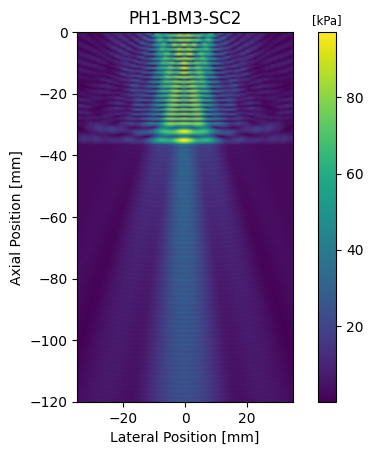

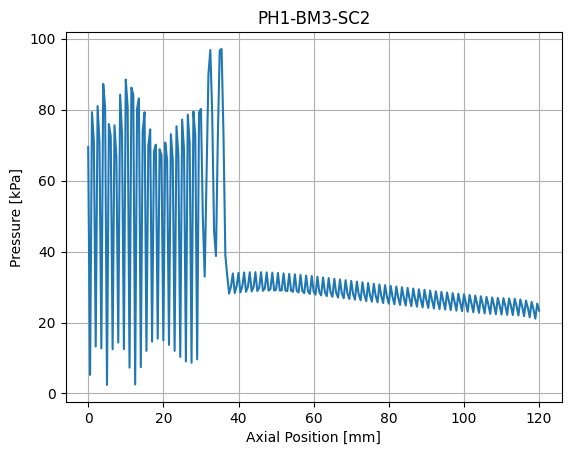

In [1]:
!pip install k-wave-python

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from kwave.data import Vector
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.checks import check_stability
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksource import kSource
from kwave.ksensor import kSensor
from kwave.utils.signals import create_cw_signals
from kwave.utils.filters import extract_amp_phase
from kwave.kspaceFirstOrder2D import kspace_first_order_2d_gpu

from kwave.options.simulation_options import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions



In [ ]:
Nx: int = 141
Nz: int = 241

dx: float = 0.5e-3
dz: float = dx





In [ ]:
# =========================================================================
# DEFINE THE MATERIAL PROPERTIES
# =========================================================================

# water
sound_speed = 1500.0 * np.ones((Nx, Nz))
density = 1000.0 * np.ones((Nx, Nz))
alpha_coeff = np.zeros((Nx, Nz))

# non-dispersive
alpha_power = 2.0

# cortical bone
sound_speed[:, 60:74] = 2800.0
density[:, 60:74] = 1850.0
alpha_coeff[:, 60:74] = 4.0

c0_min = np.min(np.ravel(sound_speed))
c0_max = np.max(np.ravel(sound_speed))

medium = kWaveMedium(sound_speed=sound_speed,
                     density=density,
                     alpha_coeff=alpha_coeff,
                     alpha_power=alpha_power)

In [ ]:
# =========================================================================
# DEFINE THE TRANSDUCER SETUP
# =========================================================================

# radius of planar transducer
radius = 10E-3

# frequency [Hz]
freq = 500e3

# source pressure [Pa]
source_amp = np.array([60e3])

# phase [rad]
source_phase = np.array([0.0])

In [ ]:
# =========================================================================
# DEFINE COMPUTATIONAL PARAMETERS
# =========================================================================

useMaxTimeStep: bool = True

# wavelength
k_min: float = c0_min / freq

# points per wavelength
ppw: float = k_min / dx

# number of periods to record
record_periods: int = 3

# compute points per period
ppp: int = 60

# CFL number determines time step
cfl: float = (ppw / ppp)

In [ ]:
# =========================================================================
# DEFINE THE KGRID
# =========================================================================

grid_size_points = Vector([Nx, Nz])

grid_spacing_meters = Vector([dx, dz])

# create the k-space grid
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)

In [ ]:
# =========================================================================
# DEFINE THE TIME VECTOR
# =========================================================================

# compute corresponding time stepping
dt = 1.0 / (ppp * freq)

# compute corresponding time stepping
dt = (c0_min / c0_max) / (float(ppp) * freq)

dt_stability_limit = check_stability(kgrid, medium)

if (useMaxTimeStep and (not np.isfinite(dt_stability_limit)) and (dt_stability_limit < dt)):
    dt_old = dt
    ppp = np.ceil(1.0 / (dt_stability_limit * freq))
    dt = 1.0 / (ppp * freq)

# calculate the number of time steps to reach steady state
t_end = np.sqrt(kgrid.x_size**2 + kgrid.y_size**2) / c0_min

# create the time array using an integer number of points per period
Nt = round(t_end / dt)

# make time array
kgrid.setTime(Nt, dt)

# calculate the actual CFL after adjusting for dt
cfl_actual = 1.0 / (dt * freq)

In [ ]:
# =========================================================================
# DEFINE THE SOURCE PARAMETERS
# =========================================================================

# create empty kWaveArray this specfies the transducer properties
karray = kWaveArray(bli_tolerance=0.01,
                    upsampling_rate=16,
                    single_precision=True)

# element positions
start_point = [-radius, kgrid.y_vec[0].item()]

end_point = [radius + dx, kgrid.y_vec[0].item()]

karray.add_line_element(start_point, end_point)

# create time varying source
source_sig = create_cw_signals(np.squeeze(kgrid.t_array),
                               freq,
                               source_amp,
                               source_phase)

# make a source object.
source = kSource()

# assign binary mask using the karray
source.p_mask = karray.get_array_binary_mask(kgrid)

# assign source pressure output in time
source.p = karray.get_distributed_source_signal(kgrid, source_sig)

In [ ]:
# =========================================================================
# DEFINE THE SENSOR PARAMETERS
# =========================================================================

sensor = kSensor()

# set sensor mask: the mask says at which points data should be recorded
sensor.mask = np.ones((Nx, Nz), dtype=bool)

# set the record type: record the pressure waveform
sensor.record = ['p']

# record the final few periods when the field is in steady state
sensor.record_start_index = kgrid.Nt - (record_periods * ppp) + 1

In [ ]:
# =========================================================================
# DEFINE THE SIMULATION PARAMETERS
# =========================================================================

DATA_CAST = 'single'
DATA_PATH = './'

input_filename = 'ph1_bm3_sc2_input.h5'
output_filename = 'ph1_bm3_sc2_output.h5'

# options for writing to file, but not doing simulations
simulation_options = SimulationOptions(
    data_cast=DATA_CAST,
    data_recast=True,
    save_to_disk=True,
    input_filename=input_filename,
    output_filename=output_filename,
    save_to_disk_exit=False,
    data_path=DATA_PATH,
    pml_inside=False)

execution_options = SimulationExecutionOptions(
    is_gpu_simulation=True,
    delete_data=False,
    verbose_level=2)

In [ ]:
# =========================================================================
# RUN THE SIMULATION
# =========================================================================

sensor_data = kspace_first_order_2d_gpu(
    medium=medium,
    kgrid=kgrid,
    source=source,
    sensor=sensor,
    simulation_options=simulation_options,
    execution_options=execution_options)

In [ ]:
# =========================================================================
# VISUALIZATION
# =========================================================================

# sampling frequency
fs = 1.0 / kgrid.dt

# get Fourier coefficients
amp, _, _ = extract_amp_phase(sensor_data['p'].T, fs, freq, dim=1, fft_padding=1, window='Rectangular')

# reshape to array
p = np.reshape(amp, (Nx, Nz), order='F')

# axes for plotting
x_vec = kgrid.x_vec
y_vec = kgrid.y_vec[0] - kgrid.y_vec

fig1, ax1 = plt.subplots(1, 1)
p1 = ax1.pcolormesh(1e3 * np.squeeze(x_vec),
                    1e3 * np.squeeze(y_vec),
                    np.flip(p.T, axis=1) / 1e3,
                    shading='gouraud', cmap='viridis')
ax1.set(xlabel='Lateral Position [mm]',
        ylabel='Axial Position [mm]',
        title='PH1-BM3-SC2')
ax1.set_aspect('equal')
cbar1 = fig1.colorbar(p1, ax=ax1)
_ = cbar1.ax.set_title('[kPa]', fontsize='small')

fig2, ax2 = plt.subplots(1, 1)
ax2.plot(-1e3 * y_vec, p[(Nx-1)//2, :] / 1e3 )
ax2.set(xlabel='Axial Position [mm]',
        ylabel='Pressure [kPa]',
        title='PH1-BM3-SC2')
ax2.grid(True)

plt.show()